Special thanks to the Carassoma team Roman Girsh, Nicolas Bernath and Leticia Fernades-Moguel for letting me draw inspiration from their code.

### Mount to drive

In [1]:
from google.colab import drive

drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


In [2]:
PATH = "/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/" 
WORKING = PATH + "SRC"
PATH_DATA = PATH + "data/Segmentation/segmented_images"                              
PATH_IMAGES = PATH + "data/Segmentation/segmented_images/test_images"
PATH_IMAGES_AUG = PATH + "data/Segmentation/augmented_data/test_image_aug"
PATH_MASKS = PATH + "/data/Segmentation/segmented_images/mask"
PATH_MASKS_AUG = PATH + "/data/Segmentation/augmented_data/mask_aug"
PATH_PREDICTIONS = PATH + "/data/Segmentation/segmented_images/trial_run"
PATH_TRUE_PREDICTIONS = PATH + "data/Segmentation/mask_generator/results"
%cd {WORKING} 
%pwd

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC


'/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/SRC'

### Packages

In [3]:
import os, shutil
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomBrightnessContrast, Crop, Rotate


from tqdm import tqdm
from functools import partial
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from scipy import ndimage
from skimage.morphology import label
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors

from keras.models import *
from keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from keras.optimizers import *
from imutils import paths
import matplotlib.pyplot as plt

import tensorflow as tf
import cv2

In [4]:
from rename import rename

In [ ]:
rename(PATH_IMAGES, "*.png", ".jpg")

In [ ]:
# make tqdm work as intended
tqdm = partial(tqdm, position=0, leave=True)

#### Generator

##### Data Augmentation

Delete former augmented photos before running augmentation with this code

In [ ]:
files_1 = glob(PATH_IMAGES_AUG + '/*')
for f in files_1:
    os.remove(f)

In [ ]:
files_2 = glob(PATH_MASKS_AUG + '/*')
for f in files_2:
    os.remove(f)

Function for data augmentation

In [11]:
def load_data(path_1, path_2, split=0.1):
    images = sorted(glob(path_1 + "/*")) #path to ultrasound images
    masks = sorted(glob(path_2 + "/*")) #path to masks

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def load_augmented_data(image_path_aug, mask_path_aug):
  train_x = sorted(glob(image_path_aug + "/*"))
  train_y =sorted(glob(mask_path_aug + "/*"))
  return train_x, train_y

In [5]:

def augment_data(images, masks, save_path_image, save_path_mask, augment=True):
    H = 256
    W = 256

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")

        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:     

            aug = RandomRotate90(p=1.0)  # p= probability, that method is applied to image 1 = 100%
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,rotate_limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            save_images = [x, x1, x2, x4]
            save_masks =  [y, y1, y2, y4]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        png = "png"
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{png}"
                tmp_mask_name = f"{mask_name}.{png}"

            else:
                tmp_img_name = f"{image_name}_{idx}.{png}"
                tmp_mask_name = f"{mask_name}_{idx}.{png}"

            image_path = os.path.join(PATH_IMAGES_AUG, tmp_img_name)
            mask_path = os.path.join(PATH_MASKS_AUG, tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


Load the Data and then augment (just the training data!)

In [13]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH_IMAGES, PATH_MASKS, split = 0.1)
print(f"Train Images: {len(train_x)} - Train Masks: {len(train_y)}")
print(f"Valid Images: {len(valid_x)} - Valid Masks: {len(valid_y)}")
print(f"Test Images: {len(test_x)} - Test Masks: {len(test_y)}")

Train Images: 307 - Train Masks: 307
Valid Images: 38 - Valid Masks: 38
Test Images: 38 - Test Masks: 38


In [14]:
augment_data(train_x, train_y, save_path_image= PATH_IMAGES_AUG, save_path_mask= PATH_MASKS_AUG, augment=True)

100%|██████████| 307/307 [09:50<00:00,  1.92s/it]


In [15]:
rename(PATH_IMAGES_AUG, "*.png", ".jpg")
rename(PATH_MASKS_AUG, "*.png", ".jpg")

In [16]:
# Takes path to images (maskes and images). 


def read_image(x, width=256, height=256, training = False):
  ''' reads image as a numpy array, resizes it, and normalizes it (pixel values 0 to 1), data format float'''
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  if training == True:
    x = tf.image.random_contrast(x, 0.9, 4.5)
    x = tf.image.random_hue(x, 0.3)
    x = tf.image.random_saturation(x, 5, 10)
  x = tf.image.resize(x, size = [width, height])
  x = x / 255.0
  #x = x.astype(np.float32)
  return x

def read_mask(x, width=256, height=256):
    ''' reads mask as a numpy array, resizes it, and normalizes it (pixel values 0 or 1), data format float'''

    
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (width, height), interpolation = cv2.INTER_NEAREST)       # resize without interpolation to prevent new pixel values
    x[np.where(x > 0)] = 1                                                   # set pixel values 255 to 1. ATTENTION: this needs to be changed if masks have different pixel values 
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x
  
def tf_dataset(x, y, batch=2, width=256, height=256, training = False):
  ''' creates a tensorflow dataset'''

  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=5000)
  dataset = dataset.map(lambda x, y: preprocess(x, y, width=width, height=height, training = training))
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(10)
  return dataset

def preprocess(x, y, width=256, height=256, training = False):
  ''' reads images for the dataset function '''
  
  def f(x, y):
      x = x.decode()
      y = y.decode()
      image = read_image(x, width, height, training = training)
      mask = read_mask(y, width, height)
      return image, mask
  image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
  image.set_shape([width, height, 3])
  mask.set_shape([width, height, 1])
  return image, mask

################################ HELPER FUNCTIONS FOR PLOTTING ########################

def read_image_PLOTTING(path, width, height):
  ''' reads an image and resizes but WITHOUT normalizing'''
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2BGRA)
  x = cv2.resize(x, (width, height))
  return x

def create_overlay(img, width=256, height=256, color1='red', color2='green'):
  '''createas a RGBA image in form of a numpy array. Loads binary, grayscale 
  or color image and transforms black values to color, and white values to trasparent'''
  img = img.resize((width, height), resample = Image.NEAREST)
  img= np.array(img.convert('RGBA')).astype(np.uint8) 
  mask_fat = (img[:,:,2] == 4)  
  mask_muscle = (img[:,:,2] == 1)
  img[:,:,3] = 0
  img[:,:,3][np.where(mask_fat| mask_muscle) ] = 255

  R, G, B = np.multiply(mcolors.to_rgb(color1),255).astype(np.uint8)
  img[:,:,0][np.where(mask_fat)] =R
  img[:,:,1][np.where(mask_fat)] =G
  img[:,:,2][np.where(mask_fat)] =B

  R, G, B = np.multiply(mcolors.to_rgb(color2),255).astype(np.uint8)
  img[:,:,0][np.where(mask_muscle)] =R
  img[:,:,1][np.where(mask_muscle)] =G
  img[:,:,2][np.where(mask_muscle)] =B
  return img

def convert_mask(path):
  img = Image.open(path)
  img = np.array(img)
  img[np.where(img== 255)] = 4
  img = Image.fromarray(img)                                            
  return img

def read_original_size(image_path):
  x = cv2.imread(image_path, cv2.IMREAD_COLOR)
  shape = x.shape
  width = shape[1]
  height = shape[0]
  color_channels = shape[2]
  return width, height, color_channels

##### data augmentation

In [ ]:

train_x, train_y = load_augmented_data(PATH_IMAGES_AUG, PATH_MASKS_AUG)
print(f"Augmented Images: {len(train_x)} - Augmented Masks: {len(train_y)}")
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")


Augmented Images: 528 - Augmented Masks: 528
Dataset: Train: 528 - Valid: 38 - Test: 38


#### Building the model

##### Loss functions

In [7]:
mean_IOU = tf.keras.metrics.MeanIoU(num_classes = 1, name=None, dtype=None)

def dice_coef_metric(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.backend.cast(y_true, dtype="float32")
    y_pred = tf.keras.backend.cast(y_pred, dtype="float32")
    y_pred_b = y_pred > 0.5
    y_pred_b = tf.keras.backend.cast(y_pred_b, dtype="float32")
    elementwise_mult = tf.math.multiply(y_true, y_pred_b)
    intersection = tf.keras.backend.sum(elementwise_mult, axis=[1, 2, 3])
    dice_coef = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred_b, axis=[1, 2, 3]) + smooth)
    return dice_coef


def dice_coef_loss(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.backend.cast(y_true, dtype="float32")
    y_pred = tf.keras.backend.cast(y_pred, dtype="float32")
    elementwise_mult = tf.math.multiply(y_true, y_pred)
    intersection = tf.keras.backend.sum(elementwise_mult, axis=[1, 2, 3])
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) + smooth)


##### Model from mobileNet

In [8]:
def mobile_net(shape):
    inputs = Input(shape=shape, name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=True, alpha=1.4)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(rate= 0.2)(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [17]:
## Currently this will load a pre-trained model. To build the model, uncomment mobile = mobile_net(shape) and comment out load_model in the line below


""" Hyperparameters """
WIDTH = 256
HEIGHT = 256
shape = (WIDTH, HEIGHT, 3)
EPOCHS = 60
BATCH_SIZE = 8

METRICS= [ dice_coef_metric, Recall(), Precision()]

#model = mobile_net(shape)
Model_save = PATH + "models/"
model = tf.keras.models.load_model(Model_save + 'image_segmentation_model.h5', custom_objects= {"dice_coef_loss": dice_coef_loss, "dice_coef_metric": dice_coef_metric})
   

train_steps = len(train_x)//BATCH_SIZE
valid_steps = len(valid_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1
if len(valid_x) % BATCH_SIZE != 0:
    valid_steps += 1

##### model compilation

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 48) 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 48) 192         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

##### Callbacks

In [18]:
#model checkpoint
checkpoint_filepath = PATH + 'models/checkpoint_for_image_segmentation.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)
#EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_dice_coef_metric",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)
#Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose = 1,
                              patience=5, min_lr=1e-9)
#CSV Logger
csv_logger = tf.keras.callbacks.CSVLogger(PATH + "data/logs/Image_segmentation.log", append = True)

callbacks = [ reduce_lr, csv_logger, checkpoint, early_stop]

#### Run the Model

In [19]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE, width=shape[0], height=shape[1], training= True)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE, width=shape[0], height=shape[1])
test_dataset = tf_dataset(test_x, test_y, batch=BATCH_SIZE, width=shape[0], height=shape[1])

In [20]:
checkpoint_filepath = PATH + 'models/checkpoint_for_image_segmentation.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/models/checkpoint_multi_input_cleaned_images.ckpt


In [21]:
model.load_weights(latest)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0ee414d860> and <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0ee414d588>).


In [22]:
model.compile(optimizer=Adam(lr=1e-4), loss= dice_coef_loss, metrics=[dice_coef_metric, Recall(), Precision()])

In [ ]:
## ONLY UNCOMMENT AND RUN IF YOU WANT TO RETRAIN THE MODEL!!
#history = model.fit(train_dataset, steps_per_epoch= train_steps, epochs=EPOCHS, validation_data= valid_dataset, validation_steps= valid_steps, callbacks= callbacks)

Epoch 1/60
66/66 [==============================] - 16s 235ms/step - loss: 0.0396 - dice_coef_metric: 0.9804 - recall_10: 0.9820 - precision_10: 0.9813 - val_loss: 0.1018 - val_dice_coef_metric: 0.9122 - val_recall_10: 0.9336 - val_precision_10: 0.9143
Epoch 2/60
66/66 [==============================] - 14s 217ms/step - loss: 0.0394 - dice_coef_metric: 0.9806 - recall_10: 0.9822 - precision_10: 0.9812 - val_loss: 0.1017 - val_dice_coef_metric: 0.9124 - val_recall_10: 0.9340 - val_precision_10: 0.9143
Epoch 3/60
66/66 [==============================] - 14s 218ms/step - loss: 0.0392 - dice_coef_metric: 0.9807 - recall_10: 0.9821 - precision_10: 0.9815 - val_loss: 0.1016 - val_dice_coef_metric: 0.9125 - val_recall_10: 0.9343 - val_precision_10: 0.9143
Epoch 4/60
66/66 [==============================] - 14s 218ms/step - loss: 0.0389 - dice_coef_metric: 0.9806 - recall_10: 0.9821 - precision_10: 0.9813 - val_loss: 0.1014 - val_dice_coef_metric: 0.9126 - val_recall_10: 0.9345 - val_precision

In [ ]:
Model_save = PATH + "models/"
model.save(Model_save + 'image_segmentation_model.h5')

#### plotting

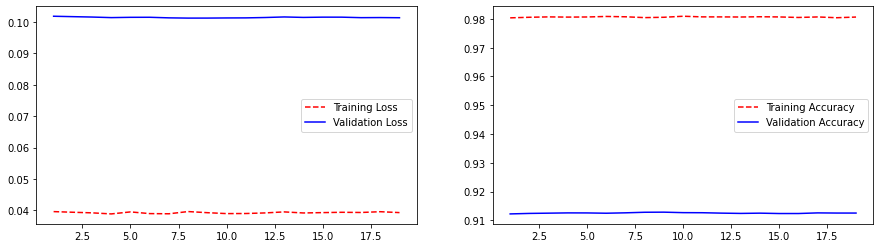

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4), facecolor = 'w')

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['dice_coef_metric']
validation_accuracy = history.history['val_dice_coef_metric']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

#####Special Plotting

In [23]:
files = glob(PATH_PREDICTIONS + '*.jpg')

for f in files:
    try:
        os.unlink(f)
    except OSError as e:
        print("Error: %s : %s" % (f, e.strerror))

In [24]:
model_input_data = test_x                                                       
binary_threshold = 0.5                                                          # pixel values above will be counted as 1 (fat)

for file_path in tqdm(model_input_data):
  file_name = os.path.basename(file_path)
  file_name, fileext = os.path.splitext(file_name)
  
  img = read_image(file_path, WIDTH, HEIGHT)                                    # reads image as a numpy array (IMAGE_SIZE_, IMAGE_SIZE_, 3)
  img = model.predict(np.expand_dims(img, axis=0))[0]                           # adds a dimension, makes prediction, and removes dimension again
  img[np.where(img > binary_threshold)] = 4 
  img[np.where(img <= binary_threshold)] = 0
  img = img.astype(np.uint8)
  img = np.concatenate([img, img, img], axis=2)                                 # create 3 equal channels for RGB

  orig_SIZE = read_original_size(file_path)
  img = cv2.resize(img, (orig_SIZE[0],                                          # resizes from (IMAGE_SIZE_, IMAGE_SIZE_, 3) to 
                         orig_SIZE[1]), interpolation = cv2.INTER_NEAREST)      # (IMAGE_SIZE_PLOTTING_WIDTH, IMAGE_SIZE_PLOTTING_HEIGHT)
  
 
  result_filepath = os.path.join(PATH_PREDICTIONS, 
                    "%s_prediction%s" % (file_name, fileext))
  cv2.imwrite(result_filepath, img)

100%|██████████| 38/38 [01:29<00:00,  2.36s/it]


In [25]:
pred_dir = glob(os.path.join(PATH_PREDICTIONS, '*.png'))
print(f"\n\n {len(pred_dir)} files in prediction folder")



 45 files in prediction folder


/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/segmented_images/test_images/006_22_2_46_0397.jpg
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation//data/Segmentation/segmented_images/mask/006_22_2_46_0397.jpg
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation//data/Segmentation/segmented_images/trial_run/006_22_2_46_0397_prediction.jpg


(None, None, None)

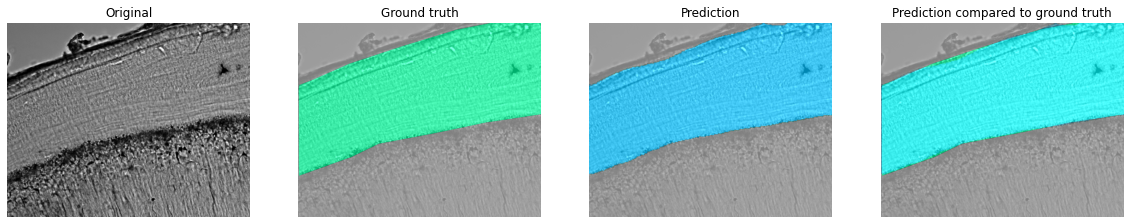

In [26]:
#### Select image to plot ####
plot_image = test_x[4]                                                          # select path of image to plot

#### Paths to image, masks, prediction. Change if folder structure is not default ####
parent_directory = os.path.dirname(os.path.dirname(plot_image))
image_directory = PATH_IMAGES
mask_directory = PATH_MASKS
prediction_directory = PATH_PREDICTIONS
base_file = os.path.basename(plot_image)
file_name, fileext = os.path.splitext(base_file)
original_SIZE = read_original_size(plot_image)                                # find original image dimensions      

PLOTTING_WIDTH = round(original_SIZE[0])                                      # resizes the images for the plot
PLOTTING_HEIGHT = round(original_SIZE[1])

mask_fat_color ='mediumspringgreen'                                              # choose a predefined matplotlib color https://matplotlib.org/3.1.0/gallery/color/named_colors.html
prediction_fat_color ='deepskyblue'  

original_path = os.path.join(image_directory, base_file)
mask_image_path = os.path.join(mask_directory, base_file)
prediction_image_path = os.path.join(prediction_directory, "%s_prediction%s" % (file_name, fileext))

############## read images as numpy arrays  ############
original = read_image_PLOTTING(original_path, PLOTTING_WIDTH, PLOTTING_HEIGHT)
mask_image = create_overlay(convert_mask(mask_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                            color1=mask_fat_color)
prediction_image = create_overlay(Image.open(prediction_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                                  color1=prediction_fat_color)

##### create the overlay images  ###########
merged_mask = cv2.addWeighted(original, 0.5, mask_image, 0.7, 0)                # choose level of transparency for first and second picture
merged_prediction = cv2.addWeighted(original, 0.5, prediction_image, 0.7, 0)
merged_prediction_mask = cv2.addWeighted(mask_image, 1, prediction_image, 0.5, 0)
merged_image_both = cv2.addWeighted(original, 0.5, merged_prediction_mask, 0.7, 0)

########  plot  #########
fig, axs = plt.subplots(1, 4, figsize=(20, 8), facecolor = 'w')

axs[0].set_title("Original")
axs[0].imshow(original)
axs[0].axis('off')

axs[1].set_title("Ground truth")
axs[1].imshow(merged_mask)
axs[1].axis('off')

axs[2].set_title("Prediction")
axs[2].imshow(merged_prediction)
axs[2].axis('off')

axs[3].set_title("Prediction compared to ground truth")
axs[3].imshow(merged_image_both)
axs[3].axis('off')



print(original_path), print(mask_image_path),print(prediction_image_path)


#### Predicting Masks on whole dataset

In [27]:
Full_image_dir = PATH + 'data/images_cleaned/'
Full_files = glob(Full_image_dir + "*")
Full_files.sort()

In [35]:
results_bin = PATH_TRUE_PREDICTIONS
results = glob(results_bin + "/*")
results.sort()

In [36]:
for filename in os.listdir(results_bin):
    file_path = os.path.join(results_bin, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [37]:
model_input_data = Full_files                                                       
binary_threshold = 0.5                                                          # pixel values above will be counted as 1 (fat)

for file_path in tqdm(model_input_data):
  file_name = os.path.basename(file_path)
  file_name, fileext = os.path.splitext(file_name)
  
  img = read_image(file_path, WIDTH, HEIGHT)                                    # reads image as a numpy array (IMAGE_SIZE_, IMAGE_SIZE_, 3)
  img = model.predict(np.expand_dims(img, axis=0))[0]                           # adds a dimension, makes prediction, and removes dimension again
  img[np.where(img > binary_threshold)] = 4 
  img[np.where(img <= binary_threshold)] = 0
  img = img.astype(np.uint8)
  img = np.concatenate([img, img, img], axis=2)                                 # create 3 equal channels for RGB

  orig_SIZE = read_original_size(file_path)
  img = cv2.resize(img, (orig_SIZE[0],                                          # resizes from (IMAGE_SIZE_, IMAGE_SIZE_, 3) to 
                         orig_SIZE[1]), interpolation = cv2.INTER_NEAREST)      # (IMAGE_SIZE_PLOTTING_WIDTH, IMAGE_SIZE_PLOTTING_HEIGHT)
  
 
  result_filepath = os.path.join(PATH_TRUE_PREDICTIONS, 
                    "%s_prediction%s" % (file_name, fileext))
  cv2.imwrite(result_filepath, img)


100%|█████████▉| 712/713 [05:50<00:00,  7.11it/s]

ValueError: ignored

In [39]:
results = glob(results_bin + "/*")
results.sort()
results[:10]

['/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/002_12_2_46_0140_prediction.tif',
 '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/002_12_2_46_0373_prediction.tif',
 '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/006_22_2_46_0152_prediction.tif',
 '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/006_22_2_46_0153_prediction.tif',
 '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/006_22_2_46_0154_prediction.tif',
 '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/010_35_NA_63.25_0289_prediction.tif',
 '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Se

This next part require an input. First is which image you want to start at (Between 0 and 2634) and how many images you want to display.

WARNING: Too many images being displayed at once will crash the notebook

Start at this pic 2
How many pics? 4
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/images_cleaned/006_22_2_46_0152.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/006_22_2_46_0152_prediction.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/images_cleaned/006_22_2_46_0153.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/006_22_2_46_0153_prediction.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/images_cleaned/006_22_2_46_0154.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Segmentation/mask_generator/results/006_22_2_46_0154_prediction.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/images_cleaned/010_35_NA_63.25_0289.tif
/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_

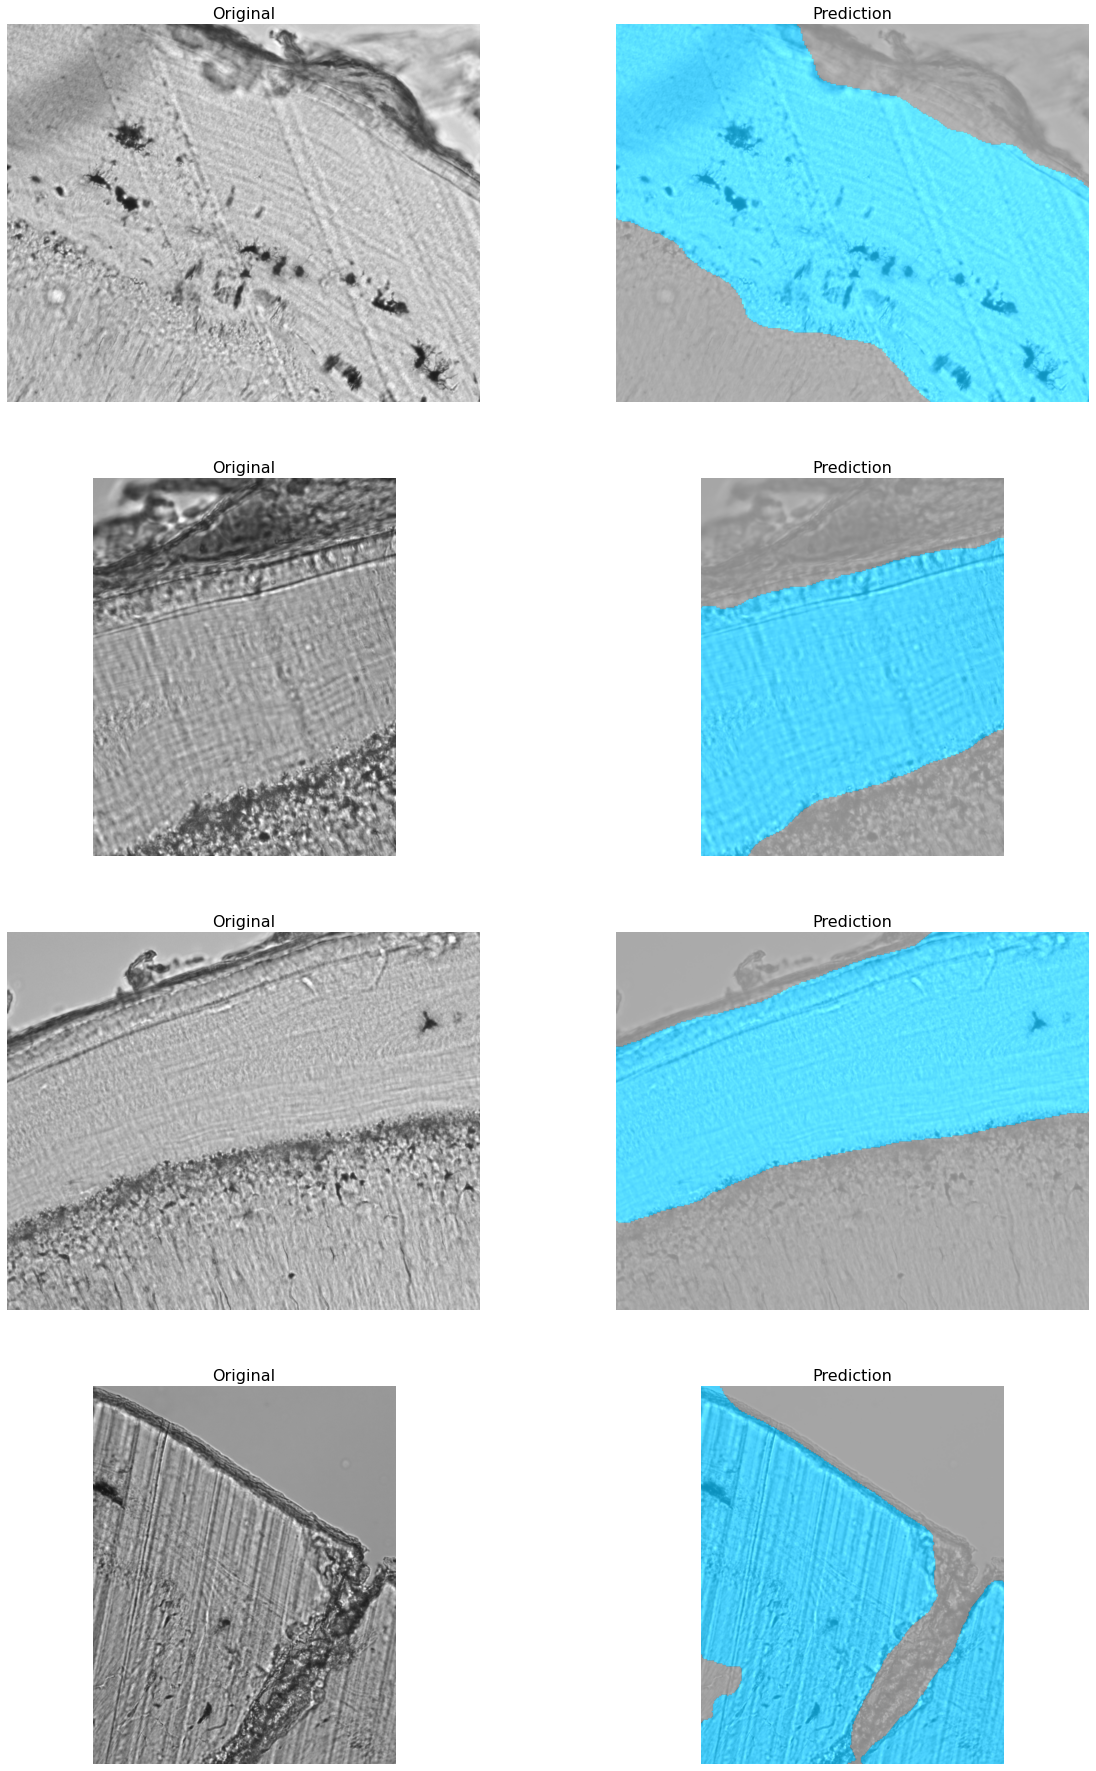

In [41]:
path = input("Start at this pic ")
num = input("How many pics? ")

fig, axs = plt.subplots(int(num), 2, figsize=(20, (8 * int(num))), facecolor = 'w')
for i in range(0, int(num)):
  plot_image = Full_files[int(path) + i]
  #### Paths to image, masks, prediction. Change if folder structure is not default ####
  parent_directory = os.path.dirname(os.path.dirname(plot_image))
  image_directory = Full_image_dir
  prediction_directory = PATH_TRUE_PREDICTIONS
  base_file = os.path.basename(plot_image)
  file_name, fileext = os.path.splitext(base_file)
  original_SIZE = read_original_size(plot_image)

  PLOTTING_WIDTH = round(original_SIZE[0])                                      # resizes the images for the plot
  PLOTTING_HEIGHT = round(original_SIZE[1])
  prediction_fat_color ='deepskyblue'

  original_path = os.path.join(image_directory, base_file)
  prediction_image_path = os.path.join(prediction_directory, "%s_prediction%s" % (file_name, ".tif"))

  original = read_image_PLOTTING(original_path, PLOTTING_WIDTH, PLOTTING_HEIGHT)
  prediction_image = create_overlay(Image.open(prediction_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, color1=prediction_fat_color)

  merged_prediction = cv2.addWeighted(original, 0.5, prediction_image, 0.7, 0)

  axs[i, 0].set_title("Original", fontsize = 16)
  axs[i, 0].imshow(original)
  axs[i, 0].axis('off')

  axs[i, 1].set_title("Prediction", fontsize = 16)
  axs[i, 1].imshow(merged_prediction)
  axs[i, 1].axis('off')

  print(original_path),print(prediction_image_path)

#### Image cropping with mask

Which image? 546


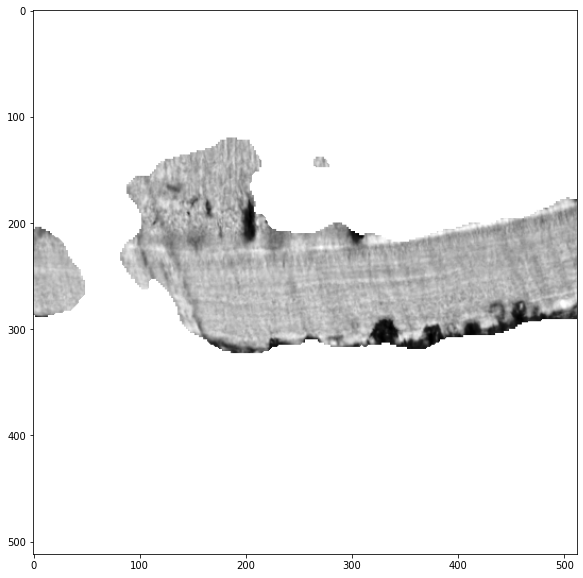

In [42]:
chooser = input("Which image? ", )

img_org = cv2.imread(Full_files[int(chooser)])
img_mask = cv2.imread(results[int(chooser)])
img_shape = img_org.shape
mask_shape = img_mask.shape

img_org = cv2.resize(img_org, (512,512), interpolation = cv2.INTER_AREA)
img_mask = cv2.resize(img_mask, (512, 512), interpolation = cv2.INTER_AREA)

for h in range(len(img_mask)):
    for w in range(len(img_mask)):
        if img_mask[h][w][0] == 0:
            for i in range(3):
                img_org[h][w][i] = 255
        else:
            continue

fig = plt.figure(figsize=(10, 10))
            
plt.imshow(img_org)

##### Cementum_only Images

In [44]:
NEW_IMAGES_PATH = PATH + "data/Cementum_only_images"

if os.path.isdir(NEW_IMAGES_PATH) != True:
  os.mkdir(NEW_IMAGES_PATH) 
  print("Directory '% s' is built!" % NEW_IMAGES_PATH)

if os.path.isdir(NEW_IMAGES_PATH) == True:
  print("Directory '% s' already exists"  % NEW_IMAGES_PATH)

Directory '/gdrive/My Drive/Colab Notebooks/TCA_project_Tomek_Thomas/tooth-annulation/data/Cementum_only_images' already exists


Delete existing images

In [45]:
for filename in os.listdir(NEW_IMAGES_PATH):
    file_path = os.path.join(NEW_IMAGES_PATH, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [46]:
for new in tqdm(range(len(Full_files))):

  #get the Image Names
  file_name = os.path.basename(Full_files[new])
  #file_name, fileext = os.path.splitext(file_name)

  #read the image and the mask
  img_org = cv2.imread(Full_files[new])
  img_mask = cv2.imread(results[new])
  ##Resizing images
  img_org = cv2.resize(img_org, (512,512), interpolation = cv2.INTER_AREA)
  img_mask = cv2.resize(img_mask, (512,512), interpolation = cv2.INTER_AREA)

  for h in range(len(img_mask)):
    for w in range(len(img_mask)):
        if img_mask[h][w][0] == 0:
            for i in range(3):
                img_org[h][w][i] = 255
        else:
            continue
  new_filepath = NEW_IMAGES_PATH
  result_filepath = os.path.join(new_filepath, file_name)
  cv2.imwrite(result_filepath, img_org)



  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 1/713 [00:00<09:50,  1.21it/s]

  0%|          | 2/713 [00:02<11:11,  1.06it/s]

  0%|          | 3/713 [00:02<10:41,  1.11it/s]

  1%|          | 4/713 [00:03<10:34,  1.12it/s]

  1%|          | 5/713 [00:04<10:35,  1.11it/s]

  1%|          | 6/713 [00:05<10:22,  1.14it/s]

  1%|          | 7/713 [00:06<11:26,  1.03it/s]

  1%|          | 8/713 [00:07<10:58,  1.07it/s]

  1%|▏         | 9/713 [00:08<12:11,  1.04s/it]

  1%|▏         | 10/713 [00:10<13:35,  1.16s/it]

  2%|▏         | 11/713 [00:11<12:35,  1.08s/it]

  2%|▏         | 12/713 [00:12<13:13,  1.13s/it]

  2%|▏         | 13/713 [00:13<13:42,  1.17s/it]

  2%|▏         | 14/713 [00:14<14:11,  1.22s/it]

  2%|▏         | 15/713 [00:16<14:24,  1.24s/it]

  2%|▏         | 16/713 [00:17<13:13,  1.14s/it]

  2%|▏         | 17/713 [00:18<12:21,  1.07s/it]

  3%|▎         | 18/713 [00:18<11:44,  1.01s/it]

  3%|▎         | 19/713 [00:19<10:56,  1.06it/s]

  3%|▎         |

IndexError: ignored